In [3]:
from navipy.trajectories import Trajectory
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import tqdm
import multiprocessing
import time
from functools import partial
%matplotlib inline

## Where are the data

In [3]:
flight_ids = ['05','06','07','08','11','17']
marker_filename_template = 'Marker/flight_{}/marker_traj.csv'

## Where we will save

In [4]:
filename_result = 'chapter_1_results/head_thorax_data.h5'

## Function

In [4]:
markers_head = ['3', '4', '5']
markers_body = ['0', '1', '2']

In [5]:
def swap_marker_index(markers,markers_head):
    """
      the triangle is defined as:
          5              1 --- 2         4 --- 5
         / \              \   /           \   /
        /   \   ---->      \ /     <=>     \ /
       4 --- 3              0               3
       
       (4+3)/2 -> 0 -> 3
       (5-(3-4)/2) -> 1 -> 4
       (5+(3-4)/2) -> 2 -> 5
    """
    
    mark3=markers.loc[:,markers_head[0]].copy()
    mark4=markers.loc[:,markers_head[1]].copy()
    mark5=markers.loc[:,markers_head[2]].copy()
    for cmp in ['x','y','z']:
        markers.loc[:,(markers_head[0],cmp)]= (mark4.loc[:,cmp]+mark3.loc[:,cmp])/2
        markers.loc[:,(markers_head[1],cmp)]= mark5.loc[:,cmp]+(mark4.loc[:,cmp]-mark3.loc[:,cmp])/2
        markers.loc[:,(markers_head[2],cmp)]= mark5.loc[:,cmp]-(mark4.loc[:,cmp]-mark3.loc[:,cmp])/2
    return markers

In [6]:
def plot_markers(markers_traj,markers_body,markers_head,flightid):

    fig, axarr = plt.subplots(2, len(markers_head),
                              figsize=(15, 6),
                              sharey=True,sharex=True)
    for plt_i, cmark_name in enumerate(markers_body):
        markers_traj.loc[:, cmark_name].plot(ax=axarr[0,plt_i],
                                        linewidth=2)
        axarr[0,plt_i].set_title(cmark_name)
        axarr[0,plt_i].set_ylabel('position [mm]')

    for plt_i, cmark_name in enumerate(markers_head):
        markers_traj.loc[:, cmark_name].plot(ax=axarr[1,plt_i],
                                        linewidth=2)
        axarr[1,plt_i].set_title(cmark_name)
        axarr[1,plt_i].set_xlabel('time [frame]')
        axarr[1,plt_i].set_ylabel('position [mm]')

    fig.savefig('Marker/flight_{}/markers.svg'.format(flightid))

In [7]:
def calc_error(head_swap,markers_bodypart):
    curr_error = pd.Series(index=head_swap.index, data=0)
    n = 0
    for m0,m1 in combinations(markers_head, 2):
        distmarker = np.sqrt(np.sum((head_swap.dropna().loc[:,m0]-head_swap.dropna().loc[:,m1])**2, axis=1))
        meandist = distmarker.mean()
        curr_error += (distmarker-meandist)**2
        n+=1
    curr_error /= n
    return curr_error



Reconstruction with error propagation

In [8]:
triangle_mode = 'y-axis=2-1'
rotconv = 'zyx'

## Example

In [9]:
flightid = '05'
# Load markers
cfilename = marker_filename_template.format(flightid)
markers_traj=pd.read_csv(cfilename,header=[0,1],index_col=0)
# select first firstn frames for testing purpose
firstn = 50
markers_traj = markers_traj.iloc[:firstn,:]
markers_traj.head()

0                                1                        \
              x          y          z          x          y          z   
1445  62.729972  13.583359  14.735621  66.192020  13.000851  14.397484   
1446  62.950086  13.759372  14.156023  66.532571  13.006932  14.240414   
1447  63.213267  13.399621  14.600627  66.624427  12.952856  14.275362   
1448  63.200138  13.510899  14.475286  66.742865  12.783131  14.698035   
1449  63.537935  13.409911  14.158250  67.122224  12.764129  14.427997   

              2                                3                       \
              x          y          z          x         y          z   
1445  64.116851  10.854341  14.935056  67.228350  8.306166  12.577445   
1446  64.416433  10.777966  14.755561  67.518654  8.343669  12.378815   
1447  64.507514  10.723638  14.768119  67.419603  7.873308  12.475877   
1448  64.782167  10.561819  14.849932  67.870097  8.035354  12.917717   
1449  64.810451  10.447656  15.259139  67.916809  7.684737  12.632200   

              4                                5                       
              x          y          z          x         y          z  
1445  68.632442  10.007712  12.019600  69.234853  8.256869  11.729091  
1446  68.882477  10.067482  11.850305  69.443552  8.034306  12.191451  
1447  69.065123   9.958772  11.899369  69.731796  8.067696  11.886975  
1448  69.274020   9.735458  12.361187  69.875740  7.984843  12.072626  
1449  69.562409   9.769475  12.056172  70.110543  7.847375  12.272490

Plot the marker positions

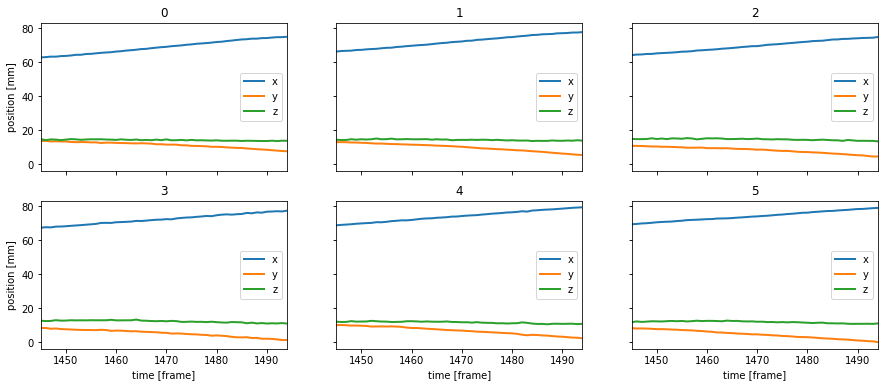

In [10]:
plot_markers(markers_traj,markers_body,markers_head,flightid)

Swap markers:

In [11]:
head_swap=swap_marker_index(markers_traj,markers_head)

In [12]:
# Calc errors
head_error = calc_error(head_swap,markers_head)
body_error = calc_error(head_swap,markers_body)
head_error.head()

1445    0.045989
1446    0.010278
1447    0.085899
1448    0.046079
1449    0.054013
dtype: float64

Text(0, 0.5, 'Count')

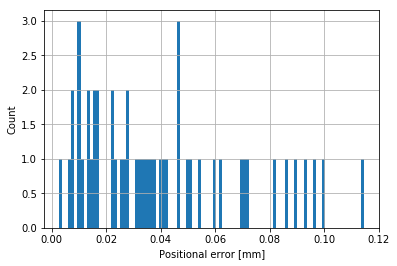

In [13]:
head_error.hist(bins=101)
plt.xlabel('Positional error [mm]')
plt.ylabel('Count')

Calculate head-thorax position orientation

In [14]:
# Calc trajectory head
print('Head')
head_traj_ex = Trajectory(rotconv=rotconv).from_markers(head_swap, 
                                                     triangle_mode, 
                                                     markers_labels=markers_head, 
                                                     error=head_error)
print('Thorax')
# Calc trajectory body
body_traj_ex = Trajectory(rotconv=rotconv).from_markers(head_swap, 
                                                 triangle_mode, 
                                                 markers_labels=markers_body, 
                                                 error=body_error)

Head
Thorax


Concatenate result in order to save 

In [15]:
head_thorax_ex = pd.concat([pd.DataFrame(head_traj_ex), 
                         pd.DataFrame(body_traj_ex)], axis=1, keys=['head','thorax'])

In [16]:
head_thorax_error_ex = pd.concat([pd.DataFrame(head_traj_ex.trajectory_error), 
                               pd.DataFrame(body_traj_ex.trajectory_error)], axis=1, keys=['head','thorax'])

In [17]:
head_thorax_ex.head()

head                                                        thorax  \
       location                            zyx                       location   
              x         y          z   alpha_0   alpha_1   alpha_2          x   
1445  68.800034  8.556893  11.918901  0.770271 -0.307391  0.260133  64.346281   
1446  69.029224  8.424729  12.165821  0.663792  0.023034  0.236027  64.633030   
1447  69.235318  8.350477  11.987191  0.697971 -0.137108  0.215762  64.781736   
1448  69.441180  8.285031  12.261568  0.770150 -0.306196  0.259580  64.908390   
1449  69.653565  8.140619  12.296389  0.672974 -0.021933  0.213626  65.156870   

                                                          
                                 zyx                      
              y          z   alpha_0   alpha_1   alpha_2  
1445  12.479517  14.689387  0.767312  0.006603  0.178150  
1446  12.514757  14.383999  0.738181  0.126137  0.167408  
1447  12.358705  14.548036  0.759602 -0.000240  0.158936  
1448  12.285283  14.674417  0.718028  0.099787  0.051479  
1449  12.207232  14.615128  0.720968  0.244536  0.256502

Define a function that will be use for multiprocessing

In [18]:
def process(flightid, markers_head=markers_head, 
                      markers_body=markers_body, 
                      triangle_mode=triangle_mode,
                      rotconv=rotconv, firstn=None, time=None):
    # Load markers
    cfilename = marker_filename_template.format(flightid)
    markers_traj=pd.read_csv(cfilename,header=[0,1],index_col=0)
    if firstn is not None:
        markers_traj = markers_traj.iloc[:firstn,:]
    if time is not None:
        print('{} will take {}'.format(flightid,time*markers_traj.dropna().shape[0]))
    # Swap markers:
    head_swap=swap_marker_index(markers_traj,markers_head)
    # Calc errors
    head_error = calc_error(head_swap,markers_head)
    body_error = calc_error(head_swap,markers_body)
    # Calc trajectory head
    head_traj = Trajectory(rotconv=rotconv).from_markers(head_swap, 
                                                         triangle_mode, 
                                                         markers_labels=markers_head, 
                                                         error=head_error)
    # Calc trajectory body
    body_traj = Trajectory(rotconv=rotconv).from_markers(head_swap, 
                                                     triangle_mode, 
                                                     markers_labels=markers_body, 
                                                     error=body_error)
    # Concatenate
    head_thorax = pd.concat([pd.DataFrame(head_traj), 
                             pd.DataFrame(body_traj)], axis=1, keys=['head','thorax'])
    head_thorax_error = pd.concat([pd.DataFrame(head_traj.trajectory_error), 
                                   pd.DataFrame(body_traj.trajectory_error)], axis=1, keys=['head','thorax'])
    return flightid, head_thorax, head_thorax_error

In [19]:
t_start = time.time()
flightid, head_thorax, head_thorax_error = process(flightid, firstn=firstn)
t_elapsed = time.time() - t_start
time = t_elapsed/head_thorax.dropna().shape[0]
print('It took {} per frame'.format(time))

It took 1.0836023950576783 per frame


In [20]:
np.testing.assert_allclose(head_thorax, head_thorax_ex)

## For all

In [21]:
func = partial(process, firstn=None, time=time)
pool = multiprocessing.Pool()
# This will show the progress
for res in tqdm.tqdm(pool.imap_unordered(func, flight_ids), total=len(flight_ids)):
    flightid, head_thorax, head_thorax_error = res 
    with pd.HDFStore(filename_result,'a') as hdfile:
        key = 'trajectories/flight_{}'.format(flightid)
        hdfile.put(key,head_thorax.astype(float))
        key = 'errors/flight_{}'.format(flightid)
        hdfile.put(key,head_thorax_error.astype(float))
pool.close()
pool.join()

  0%|          | 0/6 [00:00<?, ?it/s]

17 will take 3944.312718009949
05 will take 4366.917652082444
08 will take 5302.06651901722
06 will take 5581.635936942101
07 will take 4796.024200525284
11 will take 3589.974734826088


100%|██████████| 6/6 [2:25:31<00:00, 1455.18s/it]  


In [22]:
with pd.HDFStore(filename_result,'a') as hdfile:
    hdfile.put('flight_ids',pd.Series(flight_ids))